In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Crear fechas de pedido para el ejemplo
fecha_inicio = '2020-01-01'
fecha_fin = '2024-07-01'

# Generar fechas de pedido mensuales
fechas_pedido = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='M')

# Generar datos simulados para las facturas
np.random.seed(0)
num_facturas = len(fechas_pedido)

# Generar importe inicial y final
inicio = 300
final = 550

# Generar importes simulados con ajuste para julio y agosto
importes = np.zeros(num_facturas)
importes[0] = inicio

for i in range(1, num_facturas):
    cambio = np.random.uniform(0, 15)  # Aumento aleatorio entre 0 y 7
    if np.random.choice([True, False], p=[0.1, 0.9]):  # Probabilidad del 10% de restar
        cambio = -cambio
        
    if fechas_pedido[i].month == 7:
        importes[i] = importes[i-1] * 0.3 + cambio
    elif fechas_pedido[i].month == 8:
        importes[i] = importes[i-1] * 0.3 + cambio
    elif fechas_pedido[i].month == 9:
        importes[i] = importes[i-3] + cambio
    else:
        importes[i] = importes[i-1] + cambio
    
    # Asegurar que no sobrepase los 1300
    if importes[i] > 1000:
        importes[i] = 1000

# Asegurar que el último valor sea exactamente final
importes[-1] = final

# Redondear los importes de las facturas
importes = np.round(importes, 2)

# Generar DataFrame df_facturas
df_facturas = pd.DataFrame({
    'fecha_pedido': fechas_pedido,
    'total_factura': importes
})

# Configurar fecha_pedido como índice
df_facturas.set_index('fecha_pedido', inplace=True)




C:\Users\Benjamin\AppData\Local\Temp\ipykernel_2844\1907888754.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_pedido = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='M')


In [30]:
df_facturas

,total_factura
fecha_pedido,
2020-01-31,300.00
2020-02-29,308.23
2020-03-31,317.27
2020-04-30,323.63
2020-05-31,330.19
2020-06-30,344.65
2020-07-31,115.27
2020-08-31,43.10
2020-09-30,343.58


In [31]:
df_facturas.to_csv("facturasV3.csv")

In [32]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(df_facturas) * 0.8)
train, test = df_facturas[:train_size], df_facturas[train_size:]

In [33]:
# Construir y entrenar el modelo SARIMAX
try:
    model = SARIMAX(df_facturas['total_factura'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Hacer predicciones futuras
    future_steps = 12  # Predecir para 12 períodos futuros
    future_dates = pd.date_range(df_facturas.index[-1], periods=future_steps + 1, freq='M')[1:]
    future_predictions = model_fit.predict(start=len(df_facturas), end=len(df_facturas) + future_steps - 1)

    # Crear un DataFrame con las predicciones futuras
    future_df = pd.DataFrame({'fecha': future_dates, 'prediccion': future_predictions})



except ValueError as e:
    print(f'Error: {e}')

C:\Users\Benjamin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Benjamin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Benjamin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_284

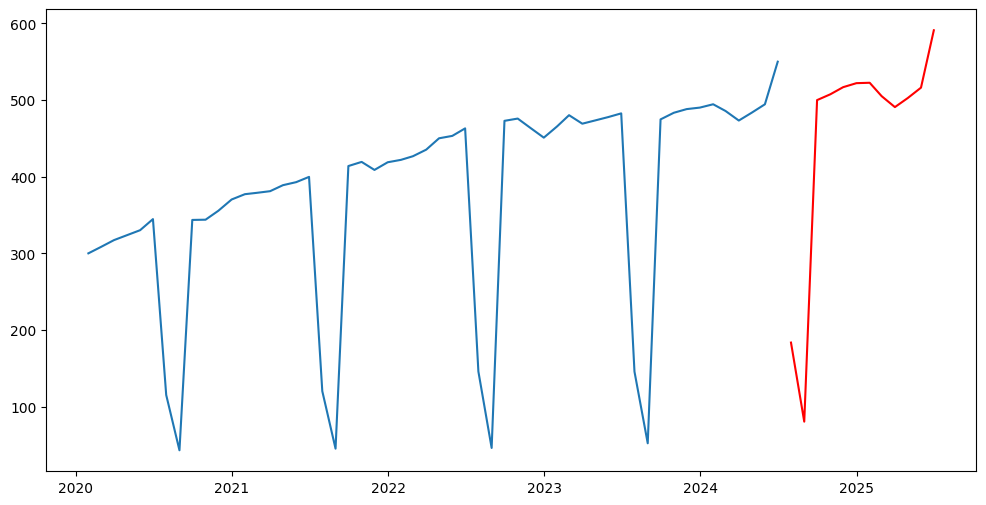

In [34]:
# Visualizar los resultados
plt.figure(figsize=(12, 6))

# Gráfico de la serie temporal de facturas
plt.plot(df_facturas.index, df_facturas['total_factura'], label='Datos Históricos')

# Gráfico de predicciones futuras
plt.plot(future_df['fecha'], future_df['prediccion'], label='Predicciones Futuras', color='red')